In [2]:
import numpy as np
import pandas as pd 
import random as rn

# tensorflow
import tensorflow.random as tfr
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Chart
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import seaborn as sns
import glob

from skimage import color, exposure
from sklearn.metrics import classification_report

import os
import cv2

# Setting the same seed for repeatability

seed = 0

np.random.seed(seed) 
rn.seed(seed)
tfr.set_seed(seed)

# Display graphs in a Jupyter
%matplotlib inline

print("Imported")

Imported


In [3]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [4]:
data_path = 'C:/Users/yalda/Downloads/3class/chest_xray'

train_path = data_path + '/train/'
test_path = data_path + '/test/'
val_path = data_path + '/val/'

In [5]:
img_size = 200

In [6]:
def read_data(data_paths):
    for data_path in data_paths:
        labels = ['BACTERIA', 'VIRUS', 'NORMAL']
        images = []
        y = []
        for label in labels:
            curr_path = data_path + label
            for img in os.listdir(curr_path):
                if ('DS' not in img):
                    image_path = os.path.join(curr_path, img)
                    image =  cv2.resize(cv2.imread(image_path), (img_size, img_size))
                    if image is not None:
                        images.append([image, label])
                
    images = np.asarray(images)
    return images

In [7]:
train = read_data([train_path])
test = read_data([test_path])

C:\Users\yalda\AppData\Local\Temp\ipykernel_2580\2430217205.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  images = np.asarray(images)


In [8]:
for i in range(10):
    np.random.shuffle(train)
    np.random.shuffle(test)

In [9]:
train_df = pd.DataFrame(train, columns=['image', 'label'])
test_df = pd.DataFrame(test, columns = ['image', 'label'])

In [10]:
train_df['label'].head()

0    BACTERIA
1      NORMAL
2    BACTERIA
3      NORMAL
4    BACTERIA
Name: label, dtype: object

C:\Users\yalda\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\yalda\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


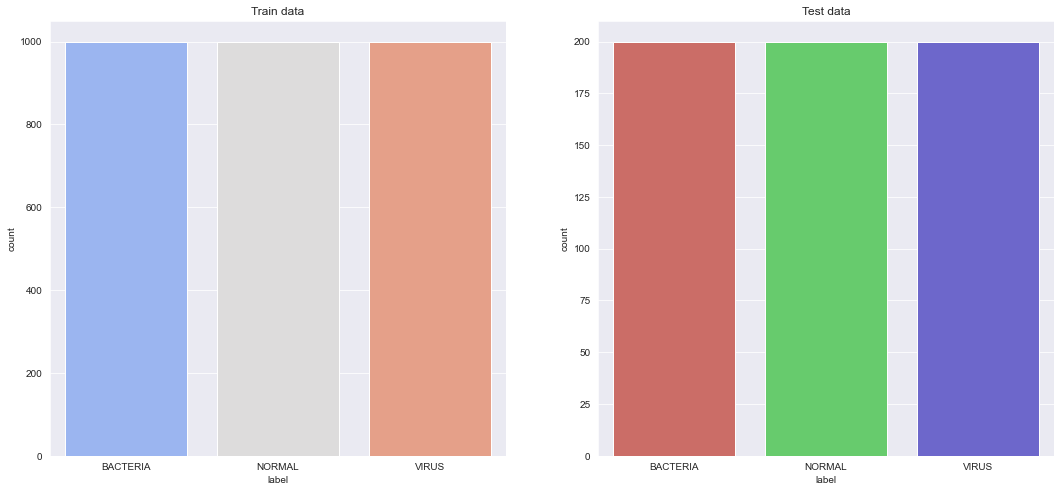

In [11]:
plt.figure(figsize=(18, 8))
sns.set_style("darkgrid")

plt.subplot(1,2,1)
sns.countplot(train_df['label'], palette = 'coolwarm')
plt.title('Train data')

plt.subplot(1,2,2)
sns.countplot(test_df['label'], palette = "hls")
plt.title('Test data')

plt.show()


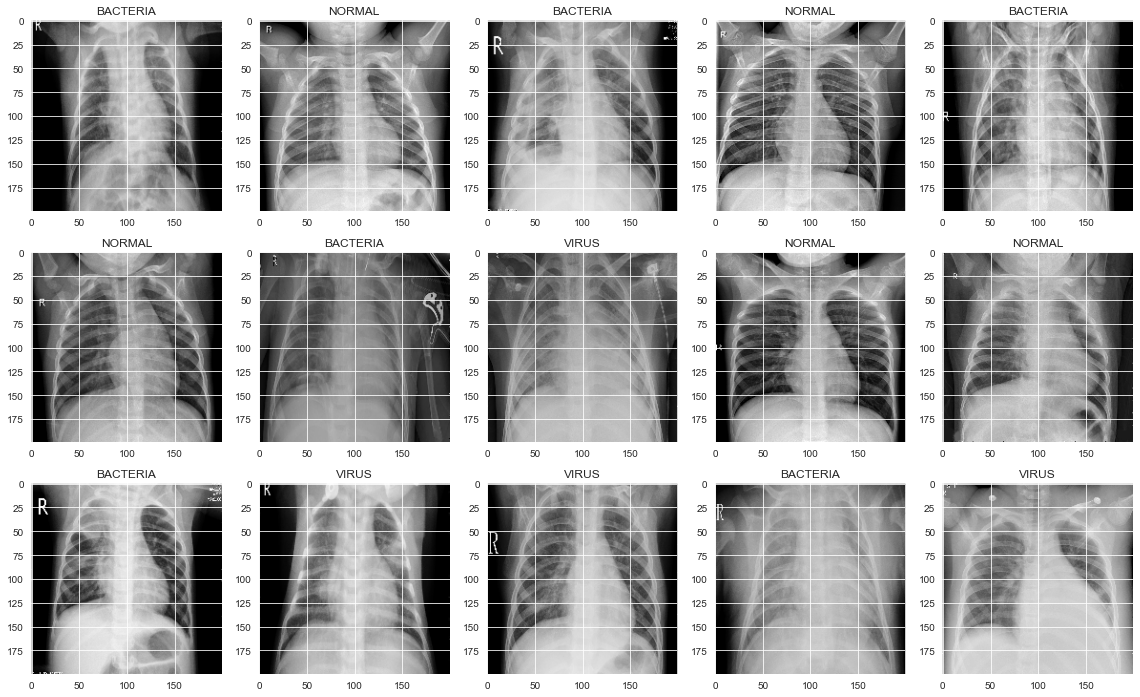

In [12]:
def Show_example_image():
    fig = plt.figure(figsize = (16, 16))
    for idx in range(15):
        plt.subplot(5, 5, idx+1)
        plt.imshow(train_df.iloc[idx]['image'])
        plt.title("{}".format(train_df.iloc[idx]['label']))
        
    plt.tight_layout()
    
Show_example_image()

In [13]:
def lung_condition(label):
    if label == 'NORMAL':
        return 0
    elif label == 'VIRUS':
        return 1
    else:
        return 2

In [14]:
def splitdata(data):
    X = []
    y = []
    for i, (val, label) in enumerate(data):
        X.append(val)
        y.append(lung_condition(label))
    return np.array(X), np.array(y)

In [15]:
np.random.shuffle(train)
np.random.shuffle(test)
X_train, y_train = splitdata(train)
X_test, y_test = splitdata(test)

In [16]:
def preprocesing_to_mlp(data):
    data1 = color.rgb2gray(data).reshape(-1, img_size * img_size).astype('float32')
    
    # Data Normalization [0, 1]
    data1 /= 255
    
    return data1

In [17]:
X_train = preprocesing_to_mlp(X_train)
X_test = preprocesing_to_mlp(X_test)

In [18]:
num_pixels = X_train.shape[1] 

# one-hot encoding for target column
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

num_classes = y_train.shape[1]

In [20]:
def draw_learning_curve(history, keys=['accuracy', 'loss']):
    plt.figure(figsize=(20,8))
    for i, key in enumerate(keys):
        plt.subplot(1, 2, i + 1)
        sns.lineplot(x = history.epoch, y = history.history[key])
        sns.lineplot(x = history.epoch, y = history.history['val_' + key])
        plt.title('Learning Curve')
        plt.ylabel(key.title())
        plt.xlabel('Epoch')
#         plt.ylim(ylim)
        plt.legend(['train', 'test'], loc='best')
    plt.show()

# Multilayer perceptron


In [21]:
callbacks1 = [ 
    EarlyStopping(monitor = 'loss', patience = 6), 
    ReduceLROnPlateau(monitor = 'loss', patience = 3), 
    ModelCheckpoint('../working/model.best1.hdf5',monitor='loss', save_best_only=True) # saving the best model
]

In [22]:
def get_mlp():
    
    return Sequential([
        #input layer is automatic generation by keras
        
        #hidden layer
        Dense(1024, input_dim = num_pixels, activation='relu'),
        
        #output layer
        Dense(num_classes, activation='softmax')
    ])

In [23]:
model = get_mlp()
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              40961024  
                                                                 
 dense_1 (Dense)             (None, 3)                 3075      
                                                                 
Total params: 40,964,099
Trainable params: 40,964,099
Non-trainable params: 0
_________________________________________________________________


In [24]:
learning_history = model.fit(X_train, y_train,
          batch_size = 64, epochs = 40, verbose = 2,
          callbacks = callbacks1,
          validation_data=(X_test, y_test));

Epoch 1/40
47/47 - 15s - loss: 1.0308 - accuracy: 0.4720 - val_loss: 0.9087 - val_accuracy: 0.5767 - lr: 0.0010 - 15s/epoch - 309ms/step
Epoch 2/40
47/47 - 10s - loss: 0.8197 - accuracy: 0.6353 - val_loss: 0.7089 - val_accuracy: 0.6917 - lr: 0.0010 - 10s/epoch - 214ms/step
Epoch 3/40
47/47 - 10s - loss: 0.6978 - accuracy: 0.6930 - val_loss: 0.6483 - val_accuracy: 0.7083 - lr: 0.0010 - 10s/epoch - 217ms/step
Epoch 4/40
47/47 - 10s - loss: 0.6432 - accuracy: 0.7043 - val_loss: 0.6153 - val_accuracy: 0.6917 - lr: 0.0010 - 10s/epoch - 206ms/step
Epoch 5/40
47/47 - 10s - loss: 0.6059 - accuracy: 0.7230 - val_loss: 0.5905 - val_accuracy: 0.7000 - lr: 0.0010 - 10s/epoch - 219ms/step
Epoch 6/40
47/47 - 10s - loss: 0.5918 - accuracy: 0.7200 - val_loss: 0.5783 - val_accuracy: 0.7050 - lr: 0.0010 - 10s/epoch - 211ms/step
Epoch 7/40
47/47 - 14s - loss: 0.5708 - accuracy: 0.7350 - val_loss: 0.5866 - val_accuracy: 0.7333 - lr: 0.0010 - 14s/epoch - 306ms/step
Epoch 8/40
47/47 - 14s - loss: 0.5603 - a

In [25]:
model = load_model('../working/model.best1.hdf5')

In [26]:
score = model.evaluate(X_test, y_test, verbose = 0)
print('Test loss: {}%'.format(score[0] * 100))
print('Test accuracy: {}%'.format(score[1] * 100))

print("MLP Error: %.2f%%" % (100 - score[1] * 100))

Test loss: 53.88701558113098%
Test accuracy: 76.33333206176758%
MLP Error: 23.67%


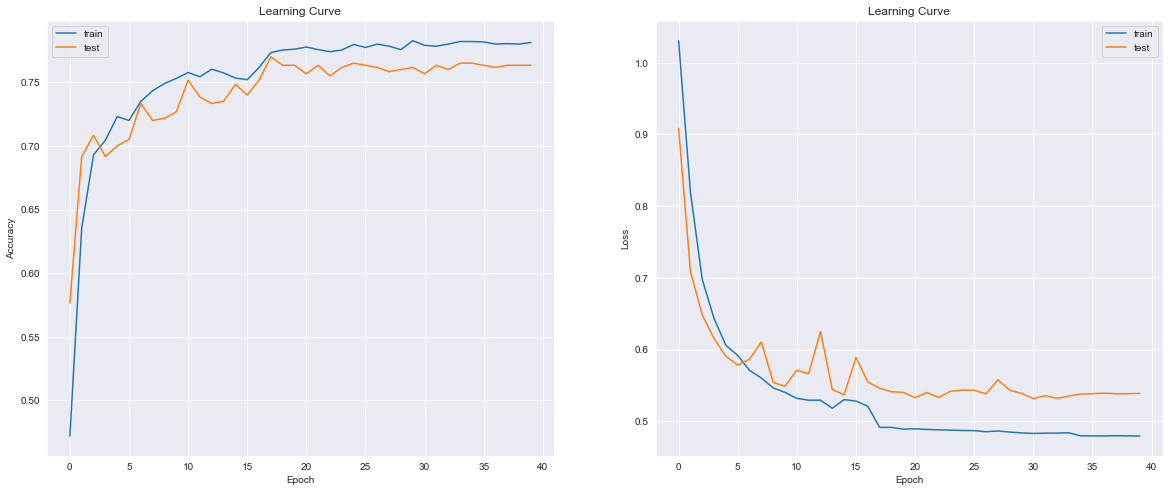

In [27]:
draw_learning_curve(learning_history)

In [28]:
callbacks2 = [ 
    EarlyStopping(monitor = 'loss', patience = 6), 
    ReduceLROnPlateau(monitor = 'loss', patience = 3), 
    ModelCheckpoint('../working/model.best2.hdf5', monitor='loss' , save_best_only=True) # saving the best model
]

In [29]:
def get_mlpv2():
    
    return Sequential([
        Dense(1024, input_dim=num_pixels, activation='relu'),
        Dropout(0.4),
        Dense(512, activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])

In [30]:
model = get_mlpv2()
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 1024)              40961024  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               65664     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 3)                

In [37]:
learning_history = model.fit(X_train, y_train,
          batch_size = 64, epochs = 100, verbose = 1,
          callbacks = callbacks2,
          validation_data=(X_test, y_test));

Epoch 1/100
47/47 [==============================] - 10s 212ms/step - loss: 0.4910 - accuracy: 0.7727 - val_loss: 0.5313 - val_accuracy: 0.7667 - lr: 1.0000e-10
Epoch 2/100
47/47 [==============================] - 10s 206ms/step - loss: 0.4793 - accuracy: 0.7747 - val_loss: 0.5313 - val_accuracy: 0.7667 - lr: 1.0000e-10
Epoch 3/100
47/47 [==============================] - 9s 197ms/step - loss: 0.4863 - accuracy: 0.7673 - val_loss: 0.5313 - val_accuracy: 0.7667 - lr: 1.0000e-10
Epoch 4/100
47/47 [==============================] - 10s 204ms/step - loss: 0.4850 - accuracy: 0.7727 - val_loss: 0.5313 - val_accuracy: 0.7667 - lr: 1.0000e-10
Epoch 5/100
47/47 [==============================] - 9s 200ms/step - loss: 0.4798 - accuracy: 0.7713 - val_loss: 0.5313 - val_accuracy: 0.7667 - lr: 1.0000e-10
Epoch 6/100
47/47 [==============================] - 9s 202ms/step - loss: 0.4766 - accuracy: 0.7800 - val_loss: 0.5313 - val_accuracy: 0.7667 - lr: 1.0000e-11
Epoch 7/100
47/47 [==================

In [38]:
model = load_model('../working/model.best2.hdf5')

In [39]:
score = model.evaluate(X_test, y_test, verbose = 0)
print('Test loss: {}%'.format(score[0] * 100))
print('Test accuracy: {}%'.format(score[1] * 100))

print("MLP Error: %.2f%%" % (100 - score[1] * 100))

Test loss: 53.17307114601135%
Test accuracy: 76.66666507720947%
MLP Error: 23.33%


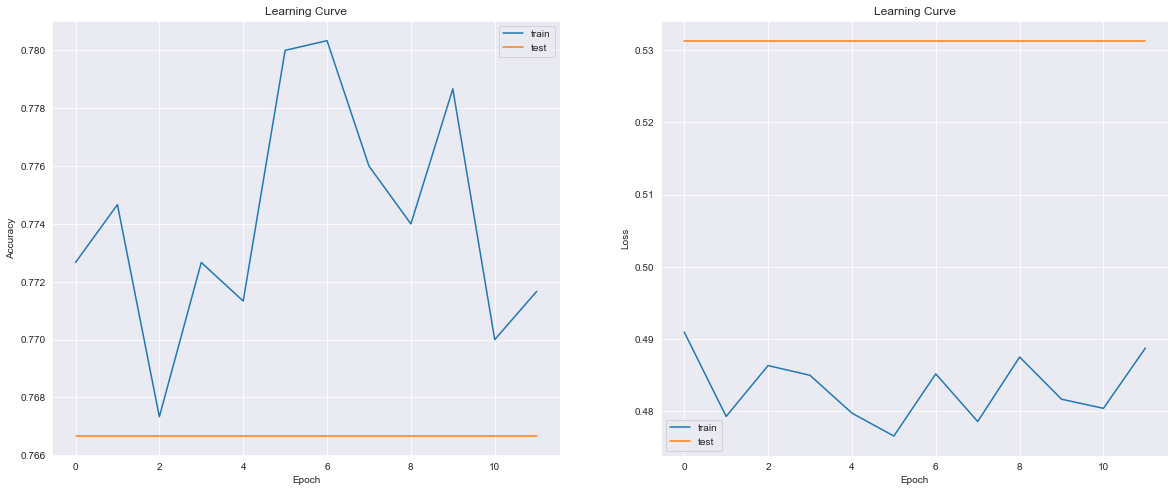

In [40]:
draw_learning_curve(learning_history)

# CNN (Convolutional_neural_network)

In [41]:
X_train, y_train = splitdata(train)
X_test, y_test = splitdata(test)

In [42]:
def preprocesing_to_cnn(data):
    data1 = color.rgb2gray(data).reshape(-1, img_size, img_size, 1).astype('float32')
    data1 /= 255
    return data1

In [43]:
X_train = preprocesing_to_cnn(X_train)
X_test = preprocesing_to_cnn(X_test)

# one-hot encoding for target column
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [44]:
num_classes = y_train.shape[1]

In [45]:
input_shape = (img_size, img_size, 1)

In [46]:
callbacks3 = [ 
    EarlyStopping(monitor = 'loss', patience = 6), 
    ReduceLROnPlateau(monitor = 'loss', patience = 3), 
    ModelCheckpoint('../working/model.best3.hdf5', monitor='loss' , save_best_only=True) # saving the best model
]

In [47]:
num_pixels 

40000

In [48]:
def get_modelcnn():
    return Sequential([
        
        Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', input_shape = input_shape),
        Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same' ),
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same' ),
        Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        
        Flatten(),
        
        Dense(512, activation='relu'),
        Dropout(0.5),
        
        Dense(256, activation='relu'),
        Dropout(0.5),
        
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation = "softmax")
        
    ])

In [49]:
model = get_modelcnn()
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 16)      160       
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 200, 16)      2320      
                                                                 
 batch_normalization (BatchN  (None, 200, 200, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 16)     0         
 )                                                               
                                                                 
 dropout_3 (Dropout)         (None, 100, 100, 16)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 100, 100, 32)     

In [50]:
learning_history = model.fit(X_train, y_train,
          batch_size = 64,
          epochs = 100,
          verbose = 1,
          callbacks = callbacks3,
          validation_data = (X_test, y_test))

Epoch 1/100
47/47 [==============================] - 225s 5s/step - loss: 2.3955 - accuracy: 0.3937 - val_loss: 1.2096 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 2/100
47/47 [==============================] - 231s 5s/step - loss: 1.0494 - accuracy: 0.4633 - val_loss: 1.3486 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 3/100
47/47 [==============================] - 228s 5s/step - loss: 0.8982 - accuracy: 0.5400 - val_loss: 2.0918 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 4/100
47/47 [==============================] - 221s 5s/step - loss: 0.8055 - accuracy: 0.5803 - val_loss: 2.0651 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 5/100
47/47 [==============================] - 236s 5s/step - loss: 0.7795 - accuracy: 0.5983 - val_loss: 1.8690 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 6/100
47/47 [==============================] - 223s 5s/step - loss: 0.7622 - accuracy: 0.6003 - val_loss: 2.0882 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 7/100
47/47 [==============================] - 376s 8s/step - lo

KeyboardInterrupt: 

In [52]:
model = load_model('../working/model.best3.hdf5')

In [53]:
score = model.evaluate(X_test, y_test, verbose = 0)
print('Test loss: {}%'.format(score[0] * 100))
print('Test accuracy: {}%'.format(score[1] * 100))

print("MLP Error: %.2f%%" % (100 - score[1] * 100))

Test loss: 65.41082859039307%
Test accuracy: 74.6666669845581%
MLP Error: 25.33%


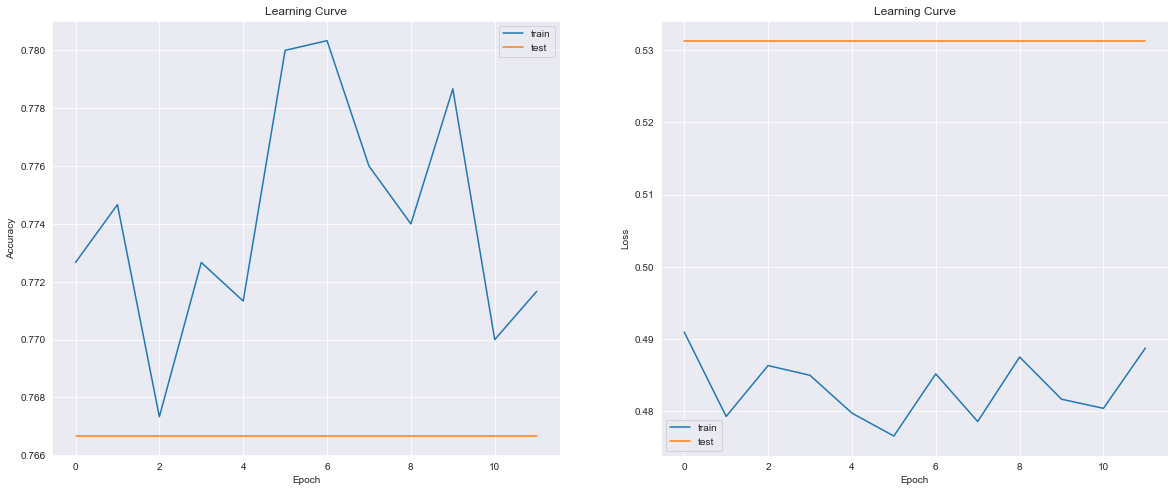

In [54]:
draw_learning_curve(learning_history)

In [55]:
pip install dill


Note: you may need to restart the kernel to use updated packages.


In [56]:
import dill
dill.dump_session('notebook_env.db')

INFO:tensorflow:Assets written to: ram://7771d6c6-ee2b-4b74-a12a-b8f3975213db/assets


INFO:tensorflow:Assets written to: ram://4bc93f5e-b7dd-42cc-a6db-968828abbf38/assets


INFO:tensorflow:Assets written to: ram://4bc93f5e-b7dd-42cc-a6db-968828abbf38/assets


INFO:tensorflow:Assets written to: ram://18d4f223-d6d3-461e-bb6c-fc5de6c4cf47/assets


INFO:tensorflow:Assets written to: ram://18d4f223-d6d3-461e-bb6c-fc5de6c4cf47/assets


INFO:tensorflow:Assets written to: ram://eab75fcc-5b35-44fe-82ca-2f3fe82288c7/assets


INFO:tensorflow:Assets written to: ram://eab75fcc-5b35-44fe-82ca-2f3fe82288c7/assets
